## Imports

In [78]:
import os
import time
import yaml

import pandas as pd

import base64

import re
from rapidfuzz import process, fuzz

import networkx as nx

from openai import OpenAI

from typing import List, Tuple
from pydantic import BaseModel

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

## Setups

In [2]:
##### Setup paths and openai api key
def get_openai_key(path_to_secrets):
    openai_api_key = None
    try:
        with open(path_to_secrets, "r") as file:
            secrets = yaml.safe_load(file)
            openai_api_key = secrets["openai_api_key"]
    except Exception as e:
        print(f"[ERROR]: {e}")

    return openai_api_key

PATH_TO_DATA_DIR = os.path.join(
    os.getcwd(),
    "data",
    "processed"
)
PATH_TO_IMAGES_DIR = os.path.join(
    os.getcwd(),
    "data",
    "images"
)

FILENAME = "2021Bouza_cleaned_for_llm.txt"

IMAGE_FILENAMES = [
    "2021Bouza_fig1.png",
    "2021Bouza_fig5.png",
    "2021Bouza_table2.png"
]

path_to_text = os.path.join(PATH_TO_DATA_DIR, FILENAME)

paths_to_images = []
for fname in IMAGE_FILENAMES:
    paths_to_images.append(os.path.join(PATH_TO_IMAGES_DIR, fname))

with open(path_to_text, "r") as file:
    raw_text = file.read()

OPENAI_API_KEY = get_openai_key(os.path.join(os.getcwd(), ".secrets.yml"))

## Functions and helpers

### openai model cost helpers

In [3]:
##### Openai MODEL_COST, MODEL_ALIASES, and cost helper
def get_cost_multiples(model_cost, model_aliases):
    cost_multiples = []
    for model, true_model in model_aliases.items():
        input_cost = model_cost[true_model]["cost_per_mil_input_tokens"]
        cost_multiples.append([input_cost, model])

    cost_multiples.sort()

    minimum_cost = min(cost[0] for cost in cost_multiples)
    for i in range(len(cost_multiples)):
        multiple = cost_multiples[i][0] / minimum_cost
        multiple = round(multiple * 2) / 2
        cost_multiples[i][0] = multiple

    return cost_multiples

MODEL_ALIASES = {
    "gpt-4.1": "gpt-4.1-2025-04-14",
    "gpt-4.1-mini": "gpt-4.1-mini-2025-04-14",
    "gpt-4.1-nano": "gpt-4.1-nano-2025-04-14",
    "gpt-4o": "gpt-4o-2024-08-06",
    "gpt-4o-mini": "gpt-4o-mini-2024-07-18",
    "o3-pro": "o3-pro-2025-06-10",
    "o3": "o3-2025-04-16",
    "o3-mini": "o3-mini-2025-01-31",
    "o4-mini": "o4-mini-2025-04-16"
}
ALIAS_FROM_TRUE_MODEL = {v: k for k, v in MODEL_ALIASES.items()}
MODEL_COST = {
    "gpt-4.1-2025-04-14": {"cost_per_mil_input_tokens": 2.00, "cost_per_mil_output_tokens": 8.00},
    "gpt-4.1-mini-2025-04-14": {"cost_per_mil_input_tokens": 0.40, "cost_per_mil_output_tokens": 1.60},
    "gpt-4.1-nano-2025-04-14": {"cost_per_mil_input_tokens": 0.10, "cost_per_mil_output_tokens": 0.40},
    "gpt-4o-2024-08-06": {"cost_per_mil_input_tokens": 2.50, "cost_per_mil_output_tokens": 10.00},
    "gpt-4o-mini-2024-07-18": {"cost_per_mil_input_tokens": 0.15, "cost_per_mil_output_tokens": 0.60},
    "o3-pro-2025-06-10": {"cost_per_mil_input_tokens": 20.00, "cost_per_mil_output_tokens": 80.00},
    "o3-2025-04-16": {"cost_per_mil_input_tokens": 2.00, "cost_per_mil_output_tokens": 8.00},
    "o3-mini-2025-01-31": {"cost_per_mil_input_tokens": 1.10, "cost_per_mil_output_tokens": 4.40},
    "o4-mini-2025-04-16": {"cost_per_mil_input_tokens": 1.10, "cost_per_mil_output_tokens": 4.40},
}

cost_multiples = get_cost_multiples(MODEL_COST, MODEL_ALIASES)
for multiple, model in cost_multiples:
    print(f"{multiple}: {model}")

1.0: gpt-4.1-nano
1.5: gpt-4o-mini
4.0: gpt-4.1-mini
11.0: o3-mini
11.0: o4-mini
20.0: gpt-4.1
20.0: o3
25.0: gpt-4o
200.0: o3-pro


### General helpers

In [40]:
##### Image helpers
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

##### Metadata print/plot helpers
def print_response_stats(response):
    print(f"Response alias model: {ALIAS_FROM_TRUE_MODEL[response.model]}")
    print(f"Response true model: {response.model}")
    print(f"Response input tokens: {response.usage.input_tokens}")
    print(f"Response output tokens: {response.usage.output_tokens}")

    # Cost calculation
    input_cost_per_mil = MODEL_COST[response.model]["cost_per_mil_input_tokens"]
    output_cost_per_mil = MODEL_COST[response.model]["cost_per_mil_output_tokens"]
    input_token_cost = (response.usage.input_tokens / 1_000_000) * input_cost_per_mil
    output_token_cost = (response.usage.output_tokens / 1_000_000) * output_cost_per_mil
    total_cost = input_token_cost + output_token_cost

    print(f"Estimated input token cost: ${input_token_cost:.4f}")
    print(f"Estimated output token cost: ${output_token_cost:.4f}")
    print(f"Total estimated cost: ${total_cost:.4f}")

### Canonicalization helpers

In [ ]:
def normalize_text(s):
    # Lowercase, replace hyphens, trim, normalize spaces
    s = s.lower().replace('-', ' ').replace('_', ' ')
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def find_similar_entities(node_names, threshold=92):
    canonical_map = {}
    checked = set()
    for node in node_names:
        if node in checked:
            continue
        # Find all with high similarity
        matches = process.extract(
            node, node_names, scorer=fuzz.token_sort_ratio, score_cutoff=threshold)
        for match, score, idx in matches:
            if match != node:
                canonical_map[match] = node
                checked.add(match)
        checked.add(node)
    return canonical_map

def extract_range(s):
    # Returns sorted tuple of all numbers in string (e.g. ('5.5','17.5'))
    matches = re.findall(r'(\d+(?:\.\d+)?)', s)
    return tuple(sorted(matches))

def canonicalize_graph_nodes(G, canonical_map):
    mapping = {}
    for n in G.nodes:
        norm = normalize_text(n)
        # Only relabel if found in canonical_map and numbers match (if any)
        canon = canonical_map.get(norm, norm)
        mapping[n] = canon
    # Relabel in the graph
    return nx.relabel_nodes(G, mapping)

### openai api call wrappers

In [ ]:
def extract_sro_from_text(raw_text, prompt_text, client, model, ExtractionTemplate, provenance_tag="text", verbose=True):
    """Extract SROs from text, tagging each with provenance."""
    messages = [{"role": "user", "content": prompt_text}]
    start = time.perf_counter()
    response = client.responses.parse(
        model=model,
        input=messages,
        text_format=ExtractionTemplate
    )
    end = time.perf_counter()
    print(f"[Text Extraction] response api call completed in {end - start}s")
    if verbose:
        print_response_stats(response)
    rdict = response.output_parsed.model_dump()
    SRO_keys = ["subject", "subject_type", "relation", "relation_type", "object", "object_type"]
    triples = []
    for sro in rdict["subject_relation_object"]:
        row = [sro[key] for key in SRO_keys]
        row.append(provenance_tag)
        triples.append(row)
    print(f"SROs extracted from text: {len(triples)}")
    return triples

def extract_sro_from_image(image_path, prompt, client, model, ExtractionTemplate, provenance_tag=None, verbose=True):
    """Extract SROs from an image, tagging with provenance (image filename by default)."""
    base64_image = encode_image(image_path)
    messages = [
        {"role": "user",
         "content": [
             {"type": "input_text", "text": prompt},
             {"type": "input_image", "image_url": f"data:image/png;base64,{base64_image}"}
         ]}
    ]
    start = time.perf_counter()
    response = client.responses.parse(
        model=model,
        input=messages,
        text_format=ExtractionTemplate
    )
    end = time.perf_counter()
    print(f"[Image Extraction - {os.path.basename(image_path)}] response api call completed in {end - start}s")
    if verbose:
        print_response_stats(response)
    rdict = response.output_parsed.model_dump()
    SRO_keys = ["subject", "subject_type", "relation", "relation_type", "object", "object_type"]
    triples = []
    tag = provenance_tag or os.path.splitext(os.path.basename(image_path))[0]
    for sro in rdict["subject_relation_object"]:
        row = [sro[key] for key in SRO_keys]
        row.append(tag)
        triples.append(row)
    print(f"SROs extracted from {os.path.splitext(image_path.split('/')[-1])[0]}: {len(triples)}")
    return triples


### Define prompt(s) and pydantic classes for structured response

In [48]:
##### Define response structure with pydantic classes and generate prompts
class SROWithMetadata(BaseModel):
    subject: str
    subject_type: str | None
    relation: str
    relation_type: str | None
    object: str
    object_type: str | None

class ExtractionTemplate(BaseModel):
    subject_relation_object: list[SROWithMetadata]

prompt_text = f"""
I am building a structured knowledge graph from the technical content of this academic paper.

**Your task:**  
Extract all relevant (subject, relation, object) triples from the following text, focusing on physical components, processes, measurements, diagnostics, or errors/faults. For each subject, relation, and object, assign a type. Avoid generic entities such as "it", "we", numbers, or section titles.

**Allowed types for subject/object:**
- component (e.g., filter, mirror, CCD, spectrometer)
- measurement device
- process (e.g., calibration, measurement, correction)
- physical parameter (e.g., wavelength, thickness)
- material
- diagnostic
- error/fault (e.g., noise, contamination, higher-order diffraction)
- physics principle (e.g., quantum yield, diffraction)
- other (if none of the above fits)

**Allowed types for relation:**  
- enables
- blocks
- measures
- removes
- records
- provides
- is type of
- causes
- calibrates
- corrects
- is part of
- other (if unsure)

**Return a list of dictionaries with this structure:**
{{
    "subject": <string>,
    "subject_type": <string or None>,
    "relation": <string>,
    "relation_type": <string or None>,
    "object": <string>,
    "object_type": <string or None>
}}

**Good examples:**
{{
    "subject": "Zr filter",
    "subject_type": "component",
    "relation": "removes",
    "relation_type": "removes",
    "object": "higher-order diffraction",
    "object_type": "error/fault"
}},
{{
    "subject": "four silicon carbide mirrors (SiC mirrors)",
    "subject_type": "component",
    "relation": "enable",
    "relation_type": "enables",
    "object": "measurement in 40–100 nm region",
    "object_type": "process"
}},
{{
    "subject": "CCD",
    "subject_type": "measurement device",
    "relation": "records",
    "relation_type": "records",
    "object": "spectrum",
    "object_type": "physical parameter"
}}

**Bad examples:**
{{
    "subject": "we",
    "subject_type": None,
    "relation": "find",
    "relation_type": None,
    "object": "agreement",
    "object_type": None
}}
{{
    "subject": "section",
    "subject_type": None,
    "relation": "contains",
    "relation_type": None,
    "object": "data",
    "object_type": None
}}
{{
    "subject": "it",
    "subject_type": None,
    "relation": "is",
    "relation_type": None,
    "object": "shown",
    "object_type": None
}}

**Further instructions:**
- Only extract triples involving key components, measurement devices, filters, diagnostics, errors, or physical processes.
- Use the full name for any element with an acronym on first occurrence, and use the full name thereafter.
- If a triple is ambiguous or too generic, skip it.
- Prefer the most specific type from the allowed list.
- Output results as a list of dictionaries, nothing else.

**Text:**
{raw_text}
"""

prompt_image = f"""
I am building a structured knowledge graph from the technical content of an academic paper on EUV spectroscopy. Here is a figure from the paper.

**Your task:**  
Extract all relevant (subject, relation, object) triples from the following text, focusing on physical components, processes, measurements, diagnostics, or errors/faults. For each subject, relation, and object, assign a type. Avoid generic entities such as "it", "we", numbers, or section titles.

**Allowed types for subject/object:**
- component (e.g., filter, mirror, CCD, spectrometer)
- measurement device
- process (e.g., calibration, measurement, correction)
- physical parameter (e.g., wavelength, thickness)
- material
- diagnostic
- error/fault (e.g., noise, contamination, higher-order diffraction)
- physics principle (e.g., quantum yield, diffraction)
- other (if none of the above fits)

**Allowed types for relation:**  
- enables
- blocks
- measures
- removes
- records
- provides
- is type of
- causes
- calibrates
- corrects
- is part of
- other (if unsure)

**Return a list of dictionaries with this structure:**
{{
    "subject": <string>,
    "subject_type": <string or None>,
    "relation": <string>,
    "relation_type": <string or None>,
    "object": <string>,
    "object_type": <string or None>
}}

**Good examples:**
{{
    "subject": "Zr filter",
    "subject_type": "component",
    "relation": "removes",
    "relation_type": "removes",
    "object": "higher-order diffraction",
    "object_type": "error/fault"
}},
{{
    "subject": "four silicon carbide mirrors (SiC mirrors)",
    "subject_type": "component",
    "relation": "enable",
    "relation_type": "enables",
    "object": "measurement in 40–100 nm region",
    "object_type": "process"
}},
{{
    "subject": "CCD",
    "subject_type": "measurement device",
    "relation": "records",
    "relation_type": "records",
    "object": "spectrum",
    "object_type": "physical parameter"
}}

**Bad examples:**
{{
    "subject": "we",
    "subject_type": None,
    "relation": "find",
    "relation_type": None,
    "object": "agreement",
    "object_type": None
}}
{{
    "subject": "section",
    "subject_type": None,
    "relation": "contains",
    "relation_type": None,
    "object": "data",
    "object_type": None
}}
{{
    "subject": "it",
    "subject_type": None,
    "relation": "is",
    "relation_type": None,
    "object": "shown",
    "object_type": None
}}

**Further instructions:**
- Only extract triples involving key components, measurement devices, filters, diagnostics, errors, or physical processes.
- Use the full name for any element with an acronym on first occurrence, and use the full name thereafter.
- If a triple is ambiguous or too generic, skip it.
- Prefer the most specific type from the allowed list.
- Output results as a list of dictionaries, nothing else.
"""

## Run API calls

In [49]:
##### Setup enviornment for openai call
model_alias = "gpt-4.1"
true_model = MODEL_ALIASES[model_alias]
print(f"True model: {true_model}")

messages = [
        {"role": "user", "content": prompt_text},
    ]
client = OpenAI(api_key=OPENAI_API_KEY)

True model: gpt-4.1-2025-04-14


In [50]:
# Extract text SROs
SRO_list = extract_sro_from_text(raw_text, prompt_text, client, true_model, ExtractionTemplate, provenance_tag="text")

# Extract image SROs
for img_path in paths_to_images:
    SRO_list += extract_sro_from_image(img_path, prompt_image, client, true_model, ExtractionTemplate)

[Text Extraction] response api call completed in -85.91711000027135s
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 12982
Response output tokens: 1752
Estimated input token cost: $0.0260
Estimated output token cost: $0.0140
Total estimated cost: $0.0400
SROs extracted from text: 45
[Image Extraction - 2021Bouza_fig1.png] response api call completed in -14.375008166767657s
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 1302
Response output tokens: 505
Estimated input token cost: $0.0026
Estimated output token cost: $0.0040
Total estimated cost: $0.0066
SROs extracted from 2021Bouza_fig1: 9
[Image Extraction - 2021Bouza_fig5.png] response api call completed in -46.89322266634554s
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 1642
Response output tokens: 530
Estimated input token cost: $0.0033
Estimated output token cost: $0.0042
Total estimated cost: 

## Subject/object canonicalization

In [77]:
all_node_names = set()
for sro in SRO_list:
    all_node_names.add(sro[0])  # subject
    all_node_names.add(sro[4])  # object
all_node_names = list(all_node_names)
print(f"Number of total node names (pre-canonicalization): {len(all_node_names)}")

norm_node_names = [normalize_text(n) for n in all_node_names]

canonical_map = find_similar_entities(norm_node_names, threshold=92)

refined_canonical_map = {}
for n, canon in canonical_map.items():
    nums_n = extract_range(n)
    nums_canon = extract_range(canon)
    if nums_n == nums_canon:
        refined_canonical_map[n] = canon
    # else, skip mapping (don't merge nodes with different ranges)

def canonicalize_sro_list(SRO_list, canonical_map):
    # canonical_map: normalized_node_name -> canonical_normalized_name
    new_SROs = []
    for sro in SRO_list:
        s_norm = normalize_text(sro[0])
        o_norm = normalize_text(sro[4])
        s_canon = canonical_map.get(s_norm, sro[0])
        o_canon = canonical_map.get(o_norm, sro[4])
        # Replace subject and object with canonical names if mapped
        sro_new = sro.copy()
        sro_new[0] = s_canon
        sro_new[4] = o_canon
        new_SROs.append(sro_new)
    return new_SROs

SRO_list_canon = canonicalize_sro_list(SRO_list, refined_canonical_map)

Number of total node names (pre-canonicalization): 88


In [90]:
node_names = set()
for sro in SRO_list:
    node_names.add(sro[0])  # subject
    node_names.add(sro[4])  # object
node_names = sorted(node_names)
print("\n".join(node_names[:10]), "\n...\n...")
# print("\n...")

df_nodes = pd.DataFrame(node_names, columns=['original_name'])
df_nodes['canonical_name'] = df_nodes['original_name']  # Start as 1:1
display(df_nodes)

1000 lines/mm transmission grating
12.5 nm
129 nm
165 nm
17 nm
6.1 nm
<115 nm
ADU to generated electrons in CCD
Al filter
CCD 
...
...


,original_name,canonical_name
0,1000 lines/mm transmission grating,1000 lines/mm transmission grating
1,12.5 nm,12.5 nm
2,129 nm,129 nm
3,165 nm,165 nm
4,17 nm,17 nm
...,...,...
83,transmission grating spectrometer,transmission grating spectrometer
84,unfiltered spectrum,unfiltered spectrum
85,unwanted radiation,unwanted radiation
86,wavelength range,wavelength range


In [ ]:
# Save node_canonicalisation list and MANUALLY fix the "higher diffraction orders/higher-order diffraction" discrepency
# df_nodes.to_csv("data/processed/node_canonicalisation.csv", index=False)

In [105]:
# Load the new, manually fixed, node_canonicalisation list
df_nodes = pd.read_csv("data/processed/node_canonicalisation.csv")

In [106]:
manual_map = dict(zip(df_nodes['original_name'], df_nodes['canonical_name']))
def manual_canonicalize_sros(SRO_list, manual_map):
    SRO_new = []
    for sro in SRO_list:
        s = manual_map.get(sro[0], sro[0])
        o = manual_map.get(sro[4], sro[4])
        sro_new = sro.copy()
        sro_new[0] = s
        sro_new[4] = o
        SRO_new.append(sro_new)
    return SRO_new

SRO_list_canon = manual_canonicalize_sros(SRO_list, manual_map)

### Build KG

In [107]:
def build_kg(SRO_list):
    """Construct a DiGraph from a list of SROs (with provenance)."""
    G = nx.DiGraph()
    for s, s_type, r, r_type, o, o_type, source in SRO_list:
        G.add_node(s, ntype=s_type, source=source)
        G.add_node(o, ntype=o_type, source=source)
        G.add_edge(s, o, label=r, rtype=r_type, source=source)
    return G

def filter_SROs_by_source(SRO_list, include=None, exclude=None):
    """Return only SROs whose source is in include or not in exclude."""
    if include:
        return [sro for sro in SRO_list if sro[6] in include]
    if exclude:
        return [sro for sro in SRO_list if sro[6] not in exclude]
    return SRO_list

def filter_SROs_by_subject(SRO_list, subject):
    """Return all SROs with a given subject (can expand to BFS subgraph later)."""
    return [sro for sro in SRO_list if sro[0] == subject]

In [108]:
G = build_kg(SRO_list_canon)

In [ ]:
def plot_kg(
    G,
    title="Knowledge Graph",
    highlight_sources=None,
    highlight_nodes=None,
    highlight_edges=None,
    node_type_color=None,
    edge_type_color=None,
    provenance_color="lime",
    highlight_provenance=False
):
    """
    Plots a KG. Options to highlight nodes/edges by source/provenance/type.
    highlight_sources: list of sources to highlight (edges/nodes)
    highlight_nodes: list of node names to highlight
    highlight_edges: list of (s, o) tuples to highlight
    highlight_provenance: if True, color border of nodes by provenance
    """

    plt.figure(figsize=(18, 10))
    pos = nx.spring_layout(G, k=0.6, seed=42)

    node_colors = []
    border_colors = []
    for n in G.nodes:
        ntype = G.nodes[n].get("ntype")
        source = G.nodes[n].get("source")
        # Color by type
        c = node_type_color.get(ntype, "grey") if node_type_color else "grey"
        node_colors.append(c)
        # Border color by provenance
        if highlight_provenance and highlight_sources and source in highlight_sources:
            border_colors.append(provenance_color)
        else:
            border_colors.append("black")

    labels = {n: str(n).replace(" ", "\n") for n in G.nodes}
    # Draw nodes (with border)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, linewidths=2, edgecolors=None)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    # Edge colors
    edge_colors = []
    for e in G.edges:
        edge_source = G.edges[e].get("source")
        # Highlight certain sources
        if highlight_sources and edge_source in highlight_sources:
            edge_colors.append(provenance_color)
        elif highlight_edges and e in highlight_edges:
            edge_colors.append(provenance_color)
        else:
            rtype = G.edges[e].get("rtype")
            edge_colors.append(edge_type_color.get(rtype, "grey") if edge_type_color else "grey")

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(title)
    
    # Node type legend
    legend_handles_nodes = [Patch(color=clr, label=lbl) for lbl, clr in node_type_color.items() if lbl]

    # Edge/relation type legend
    legend_handles_edges = [Line2D([0], [0], color=clr, lw=3, label=lbl)
                            for lbl, clr in edge_type_color.items() if lbl]

    # Place both legends
    # Place the node legend first and add it as an artist
    legend1 = plt.legend(handles=legend_handles_nodes, title="Node Types", loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.gca().add_artist(legend1)

    # Now add the edge legend (will appear just below the node legend)
    legend2 = plt.legend(handles=legend_handles_edges, title="Relation Types", loc='upper left', bbox_to_anchor=(1.01, 0.60))
    
    plt.tight_layout()
    plt.show()

type_color = {
    "component": "skyblue", "measurement device": "gold", "process": "lightgreen",
    "diagnostic": "violet", "error/fault": "salmon", "physical parameter": "orange",
    "material": "lightgrey", "physics principle": "aqua", "other": "lightpink", None: "grey"
}
relation_color = {
    "enables": "green", "removes": "red", "measures": "blue", "records": "purple",
    "provides": "black", "calibrates": "brown", "other": "grey", None: "grey"
}

### Create full knowledge graph

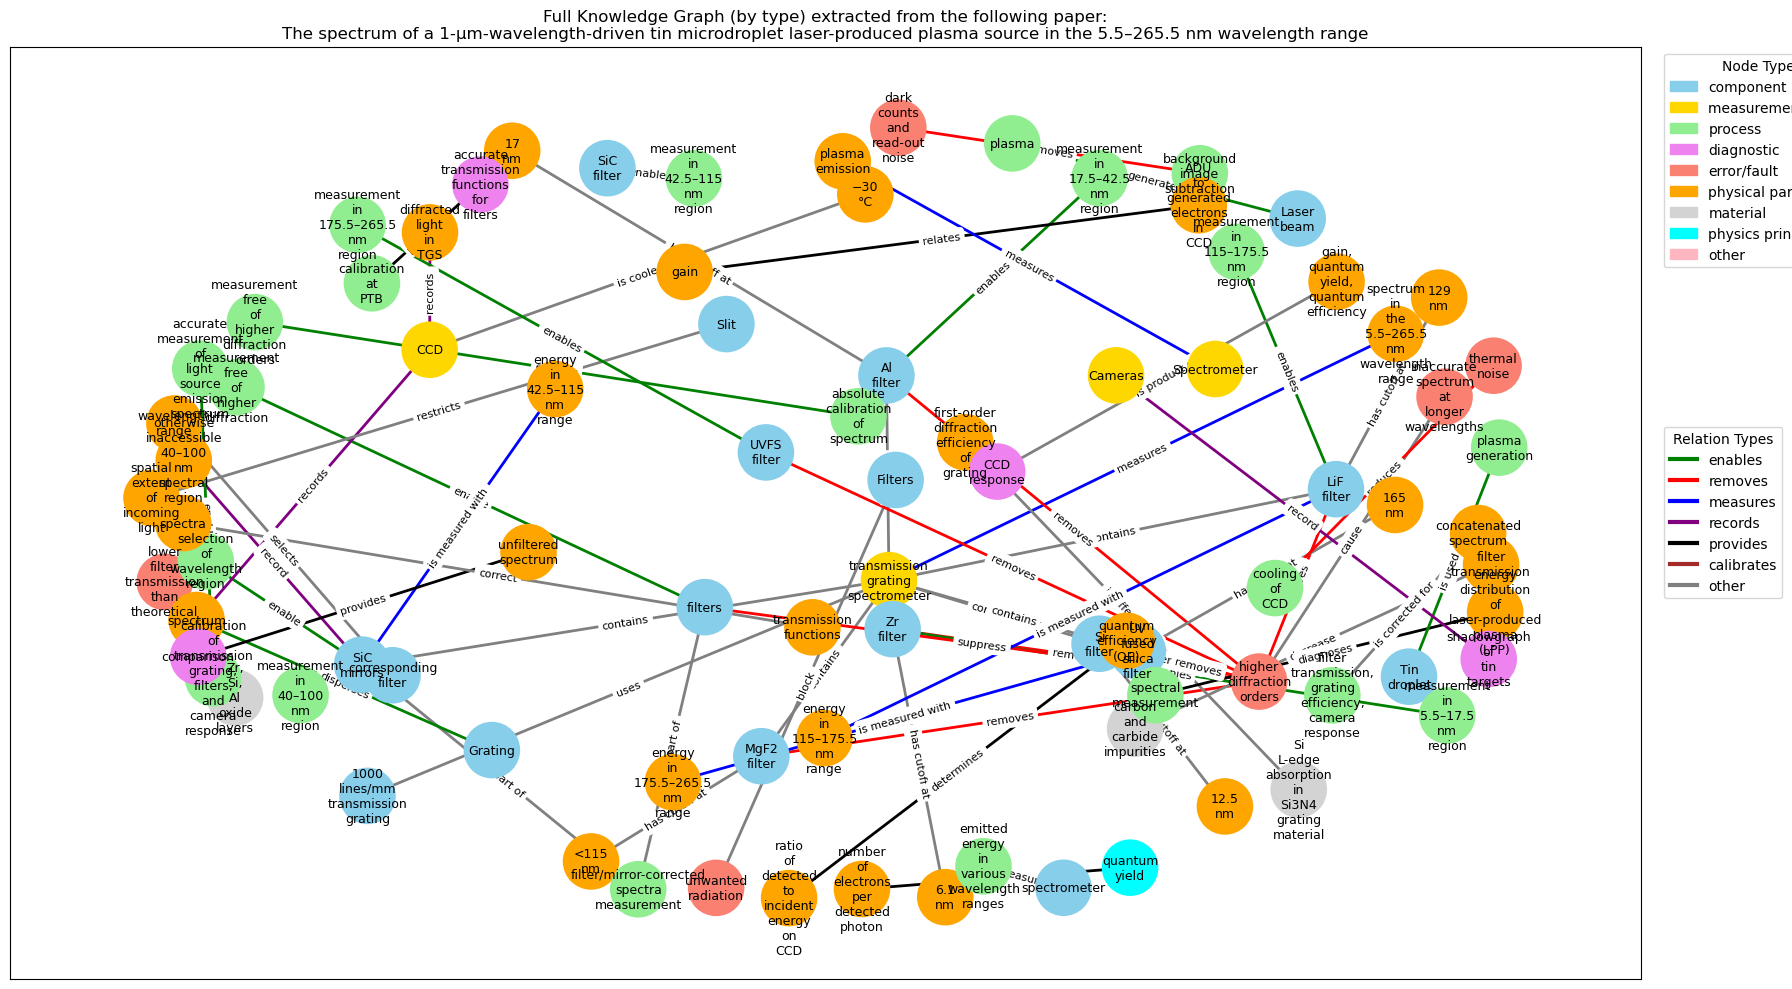

In [122]:
paper_title = "The spectrum of a 1-μm-wavelength-driven tin microdroplet laser-produced plasma source in the 5.5–265.5 nm wavelength range"
plot_kg(G, title=f"Full Knowledge Graph (by type) extracted from the following paper:\n{paper_title}", node_type_color=type_color, edge_type_color=relation_color)

### Create knowledge graph only including nodes with image provenance

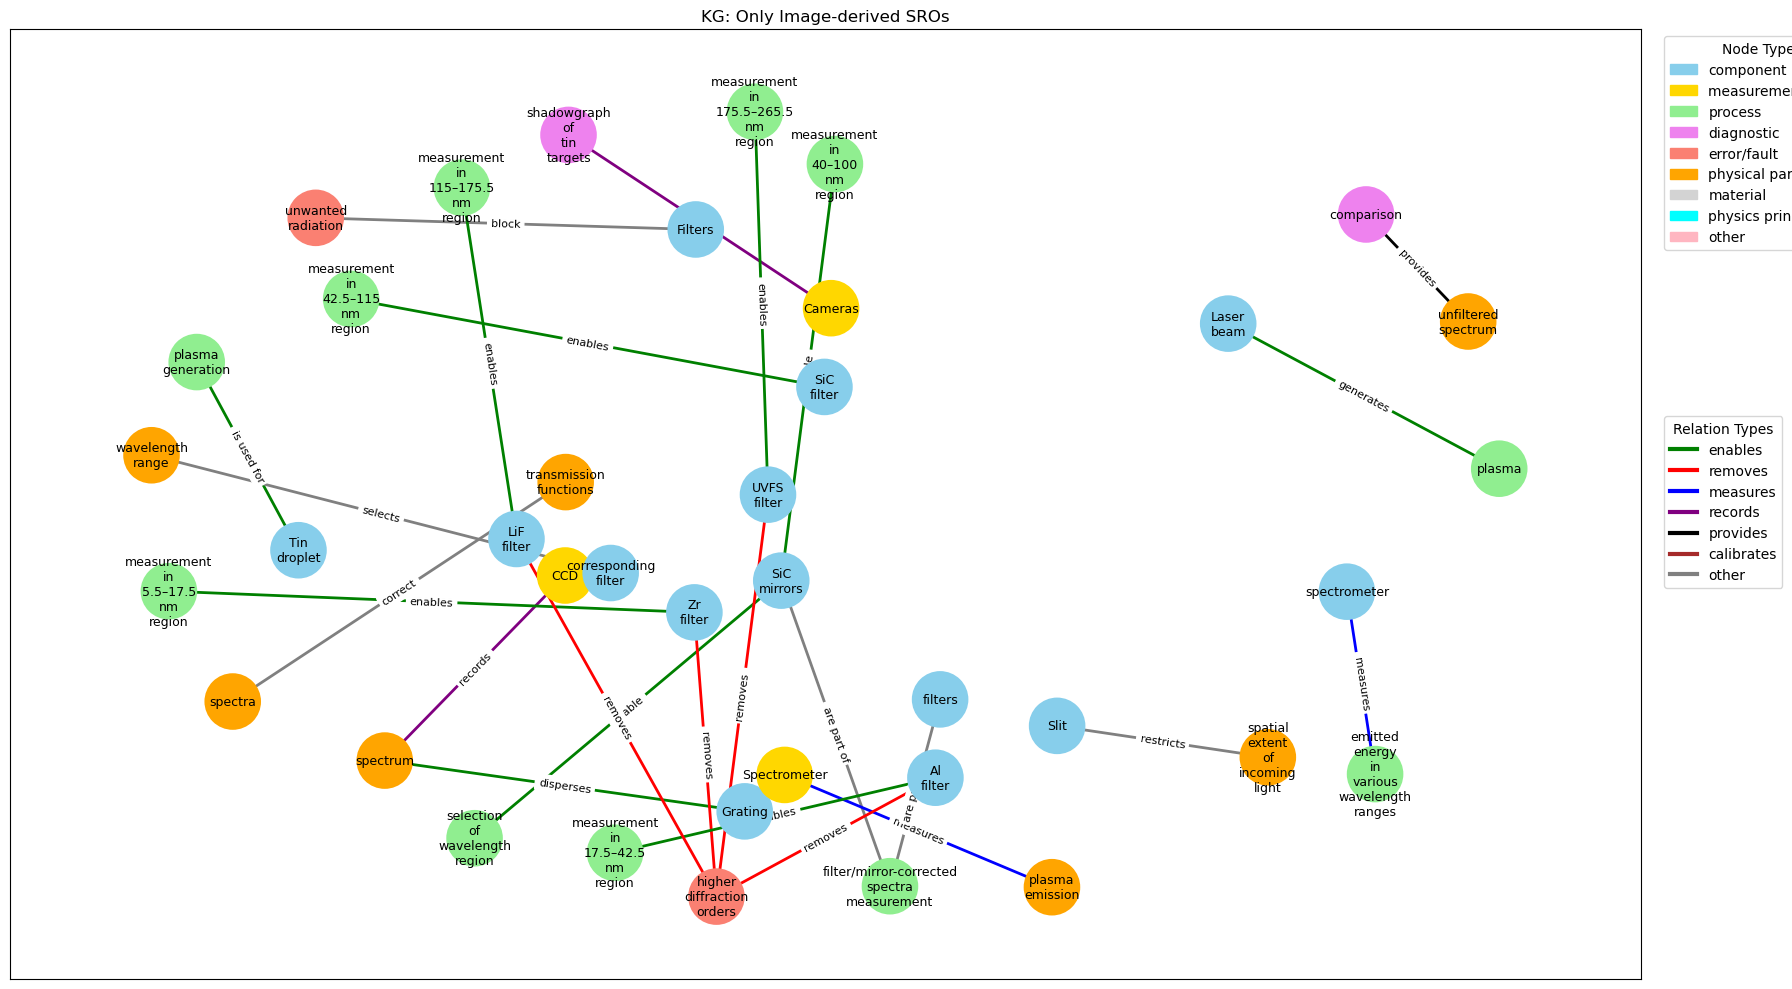

In [111]:
image_sources = [os.path.splitext(os.path.basename(f))[0] for f in paths_to_images]
SRO_image = filter_SROs_by_source(SRO_list_canon, include=image_sources)
G_img = build_kg(SRO_image)
plot_kg(G_img, title="KG: Only Image-derived SROs", node_type_color=type_color, edge_type_color=relation_color)


### Create length-2 knowledge graph, starting from the node with the most connections (in this case "transmission grating spectrometer" (degree=9))

In [128]:
# Find node with the most connections (degree)
node_degrees = dict(G.degree())
max_node = max(node_degrees, key=node_degrees.get)
print(f"Node with the most connections: '{max_node}' (degree={node_degrees[max_node]})")


Node with the most connections: 'transmission grating spectrometer' (degree=9)


In [129]:
# Get 1-hop neighbors
neighbors1 = set(G.neighbors(max_node)).union([n for n in G.predecessors(max_node)])
# Get 2-hop neighbors
neighbors2 = set()
for n in neighbors1:
    neighbors2.update(G.neighbors(n))
    neighbors2.update([m for m in G.predecessors(n)])
# All nodes to include: max_node + 1-hop + 2-hop
sub_nodes = set([max_node]).union(neighbors1).union(neighbors2)
subG = G.subgraph(sub_nodes)

/var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_46366/933047133.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


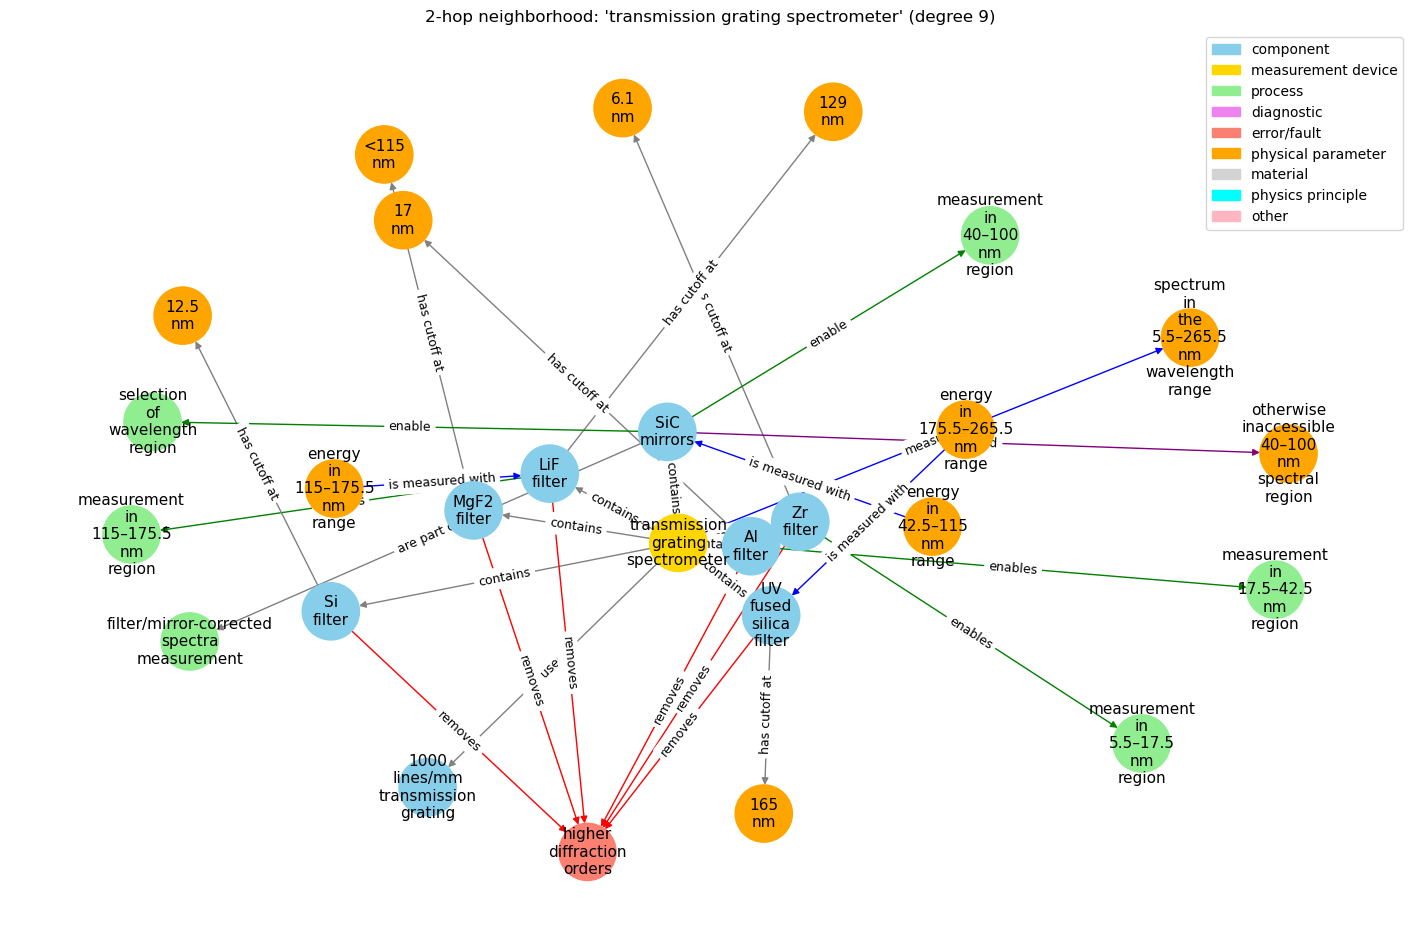

In [130]:
sub_node_colors = [type_color.get(subG.nodes[n].get("ntype"), "grey") for n in subG.nodes]
sub_edge_colors = [relation_color.get(subG.edges[e].get("rtype"), "grey") for e in subG.edges]

plt.figure(figsize=(14, 9))
pos = nx.spring_layout(subG, k=0.7, seed=43)
nx.draw(
    subG, pos,
    with_labels=True,
    labels={n: n.replace(" ", "\n") for n in subG.nodes},
    node_color=sub_node_colors,
    edge_color=sub_edge_colors,
    node_size=1700,
    font_size=11
)
edge_labels = nx.get_edge_attributes(subG, 'label')
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_size=9)
plt.title(f"2-hop neighborhood: '{max_node}' (degree {node_degrees[max_node]})")
legend_handles = [Patch(color=color, label=typ) for typ, color in type_color.items() if typ]
plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("data/processed/output/2hop_max_node.png", dpi=300)
plt.show()

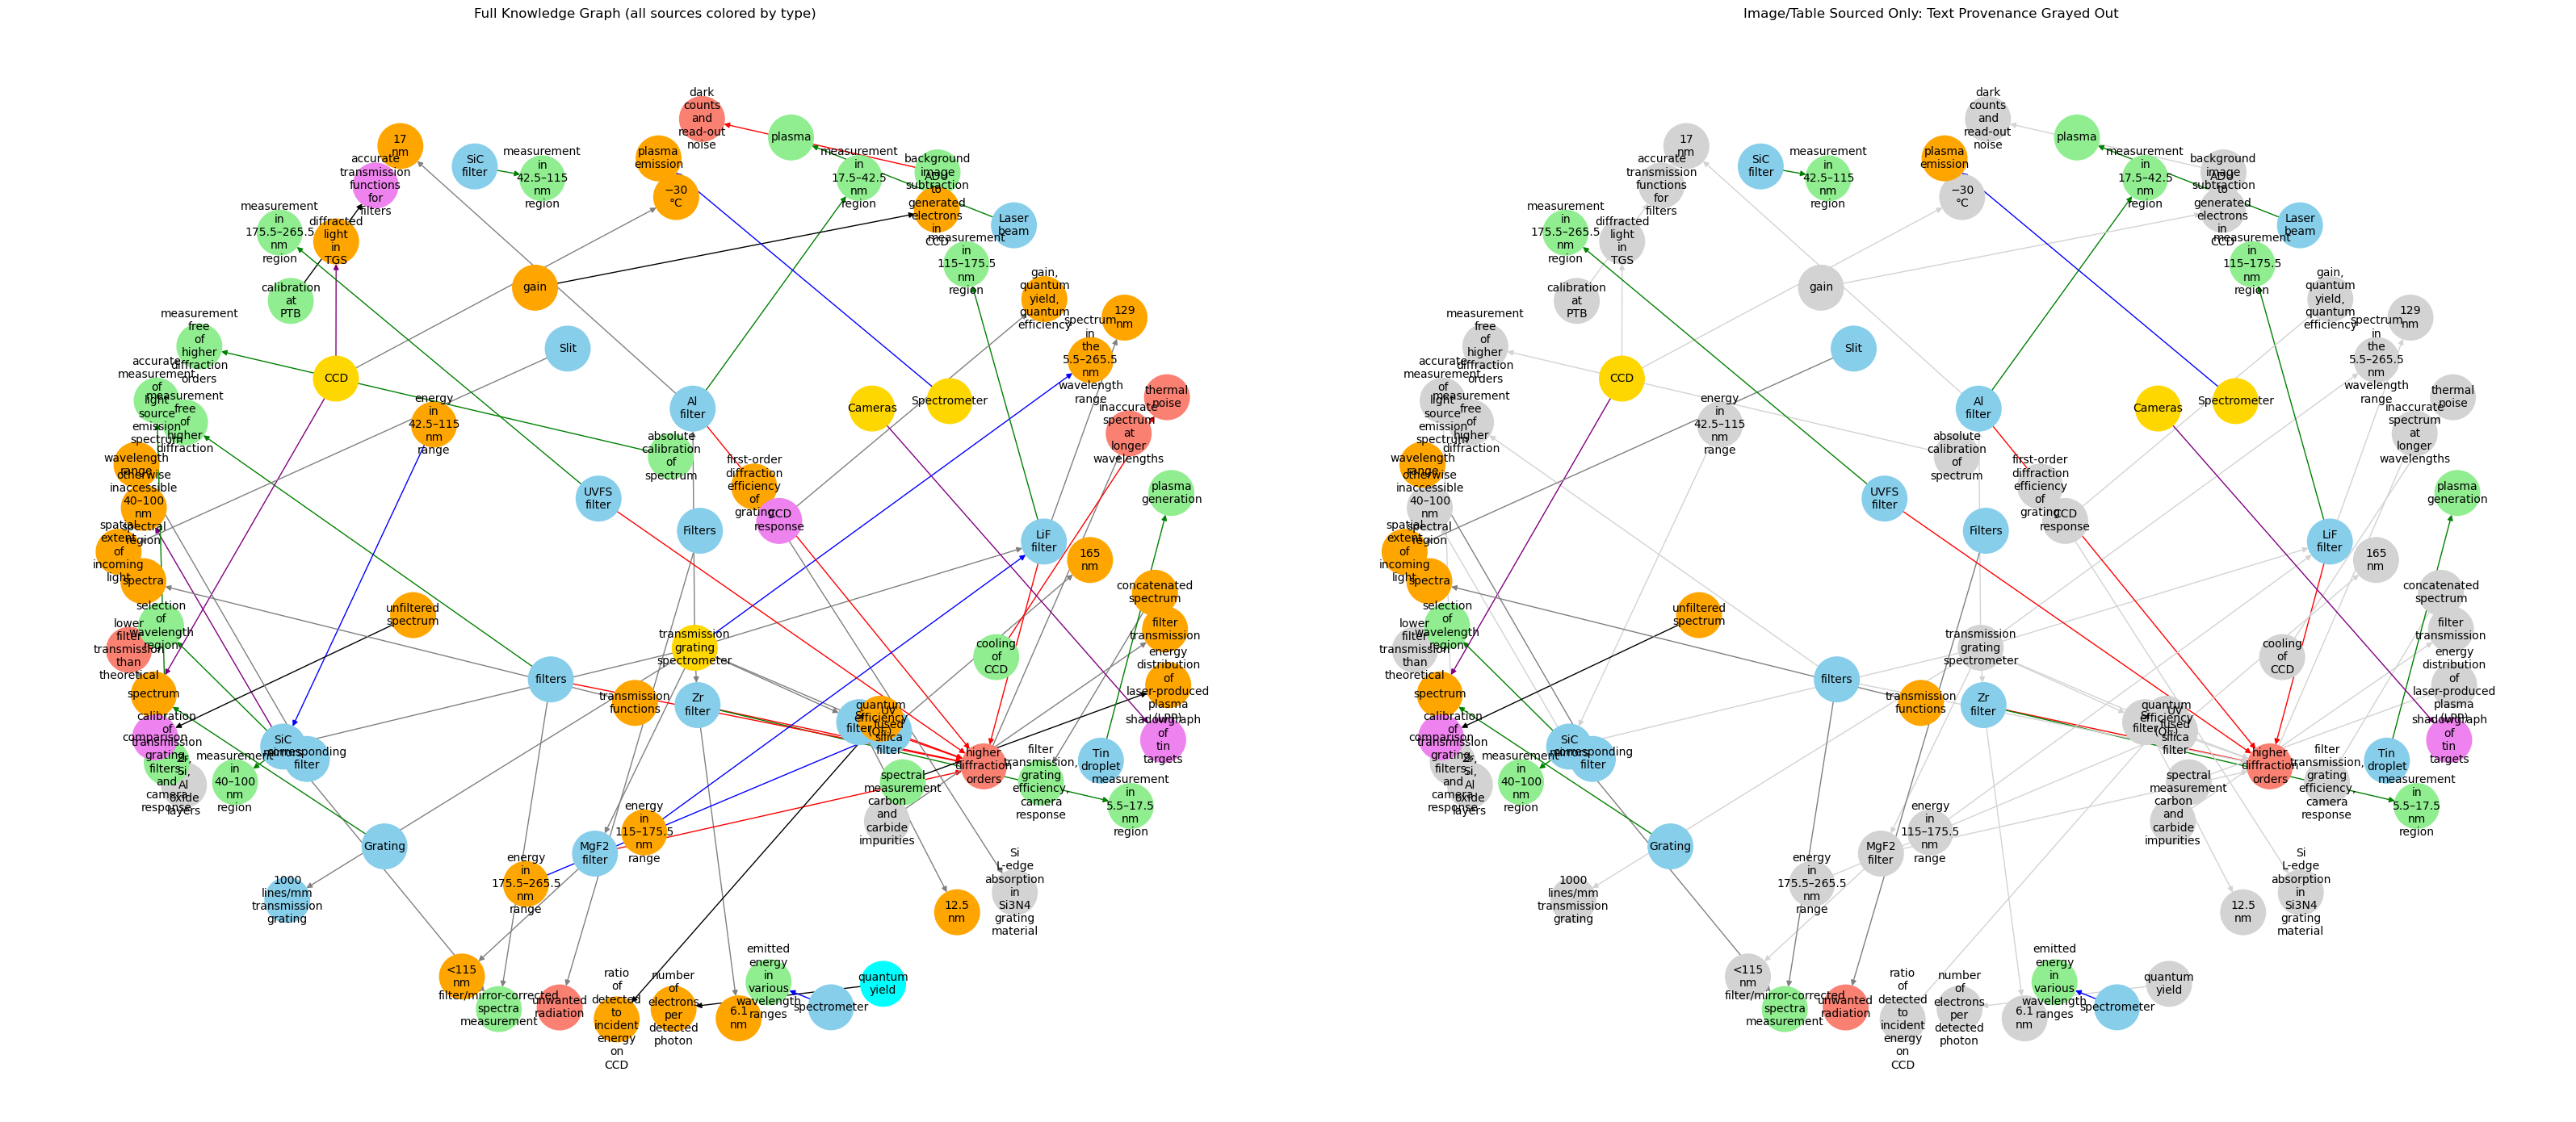

In [118]:
def get_provenance_color(provenance, image_sources, base_color, grey_color="lightgrey"):
    if provenance in image_sources:
        return base_color
    return grey_color

# List of image sources
image_sources = [os.path.splitext(os.path.basename(f))[0] for f in paths_to_images]

# Main (color everything)
node_colors_main = [type_color.get(G.nodes[n].get("ntype"), "grey") for n in G.nodes]
edge_colors_main = [relation_color.get(G.edges[e].get("rtype"), "grey") for e in G.edges]

# Grey out text provenance
node_colors_imgonly = [
    get_provenance_color(G.nodes[n].get("source"), image_sources, type_color.get(G.nodes[n].get("ntype"), "grey"))
    for n in G.nodes
]
edge_colors_imgonly = [
    get_provenance_color(G.edges[e].get("source"), image_sources, relation_color.get(G.edges[e].get("rtype"), "grey"))
    for e in G.edges
]

fig, axs = plt.subplots(1, 2, figsize=(32, 14))
pos = nx.spring_layout(G, k=0.6, seed=42)

# (i) Main graph
nx.draw(
    G, pos, ax=axs[0],
    with_labels=True,
    labels={n: n.replace(" ", "\n") for n in G.nodes},
    node_color=node_colors_main,
    edge_color=edge_colors_main,
    node_size=1600,
    font_size=10
)
axs[0].set_title("Full Knowledge Graph (all sources colored by type)")

# (ii) Image-only colored graph (text provenance greyed out)
nx.draw(
    G, pos, ax=axs[1],
    with_labels=True,
    labels={n: n.replace(" ", "\n") for n in G.nodes},
    node_color=node_colors_imgonly,
    edge_color=edge_colors_imgonly,
    node_size=1600,
    font_size=10
)
axs[1].set_title("Image/Table Sourced Only: Text Provenance Grayed Out")

plt.tight_layout()
plt.savefig("data/processed/output/kg_img_vs_all.png", dpi=300)
plt.show()